<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting VCB  stock price with Neural Networks (DNN only)



## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv


## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('excel_vcb.csv')

In [5]:
data.head

<bound method NDFrame.head of       time <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0        0      VCB      20090630  16.2426  16.2426  16.2426  16.2426   
1        1      VCB      20090701  16.2426  17.0547  16.1072  16.3779   
2        2      VCB      20090702  16.3779  16.3779  15.5658  15.7011   
3        3      VCB      20090703  15.7011  15.7011  15.1597  15.1597   
4        4      VCB      20090706  15.1597  15.8365  15.1597  15.8365   
...    ...      ...           ...      ...      ...      ...      ...   
3459  3459      VCB      20230515  92.8000  93.0000  91.2000  91.7000   
3460  3460      VCB      20230516  91.7000  93.1000  91.3000  92.6000   
3461  3461      VCB      20230517  92.6000  93.0000  92.3000  92.8000   
3462  3462      VCB      20230518  92.8000  96.0000  92.2000  95.0000   
3463  3463      VCB      20230519  95.0000  95.0000  92.6000  93.0000   

      <Volume>  
0       294070  
1      6248390  
2      1515670  
3       899720  
4      1

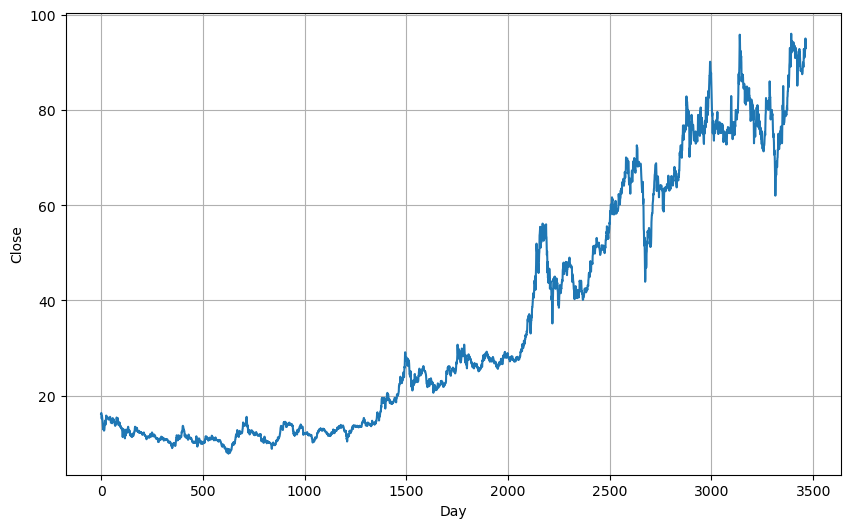

In [6]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the day number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Stock Price

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3464 points in the dataset and you will use the first 3000 for training.

In [7]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [10]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [12]:
# Get initial weights
init_weights = model.get_weights()

In [13]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 64s 223ms/step - loss: 66.2794 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 10s 105ms/step - loss: 27.9870 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 10s 102ms/step - loss: 11.0796 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 10s 104ms/step - loss: 8.6648 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 10s 108ms/step - loss: 6.6362 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 11s 107ms/step - loss: 5.3179 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 10s 103ms/step - loss: 4.3051 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 10s 102ms/step - loss: 3.3771 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 11s 110ms/step - loss: 2.6351 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 11s 115ms/step - loss: 2.1981 - lr: 2.8184e

93/93 [==============================] - 7s 67ms/step - loss: 8.7053 - lr: 1.2589e-04
Epoch 84/100
93/93 [==============================] - 6s 66ms/step - loss: 9.4351 - lr: 1.4125e-04
Epoch 85/100
93/93 [==============================] - 6s 66ms/step - loss: 22.4565 - lr: 1.5849e-04
Epoch 86/100
93/93 [==============================] - 7s 67ms/step - loss: 19.6160 - lr: 1.7783e-04
Epoch 87/100
93/93 [==============================] - 7s 67ms/step - loss: 26.9536 - lr: 1.9953e-04
Epoch 88/100
93/93 [==============================] - 7s 69ms/step - loss: 26.0856 - lr: 2.2387e-04
Epoch 89/100
93/93 [==============================] - 7s 70ms/step - loss: 21.6259 - lr: 2.5119e-04
Epoch 90/100
93/93 [==============================] - 7s 69ms/step - loss: 43.9393 - lr: 2.8184e-04
Epoch 91/100
93/93 [==============================] - 7s 70ms/step - loss: 48.8079 - lr: 3.1623e-04
Epoch 92/100
93/93 [==============================] - 7s 68ms/step - loss: 44.4250 - lr: 3.5481e-04
Epoch 93/100
93

(1e-08, 0.001, 0.0, 100.0)

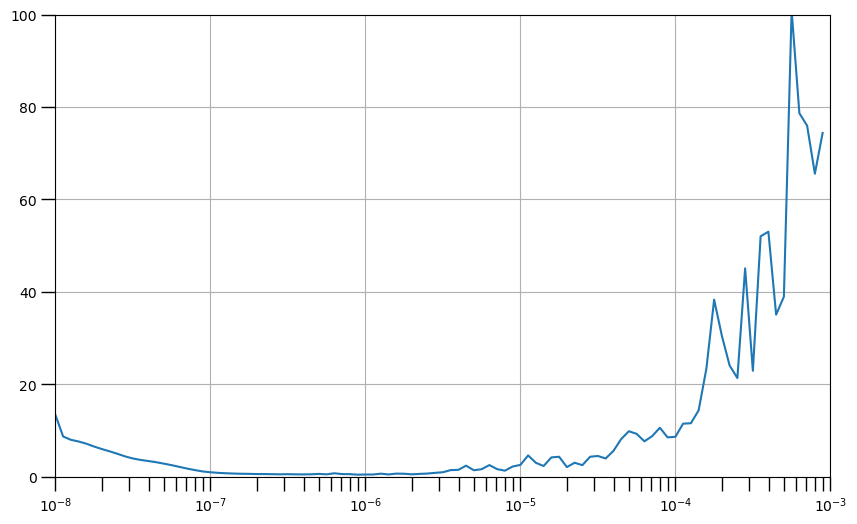

In [13]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [15]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 5ms/step - loss: 18.8093 - mse: 524.2028
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 1.0183 - mse: 4.9244
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 0.9223 - mse: 4.4375
Epoch 4/100
93/93 [==============================] - 1s 4ms/step - loss: 0.8424 - mse: 3.8830
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7841 - mse: 3.5074
Epoch 6/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7704 - mse: 3.4154
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7561 - mse: 3.3156
Epoch 8/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7418 - mse: 3.2255
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7316 - mse: 3.1786
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7309 - mse: 3.1710
Epoch 11/100
93/93 [==============================] - 1s

## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MSE of around 3. 

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 0s 16ms/step


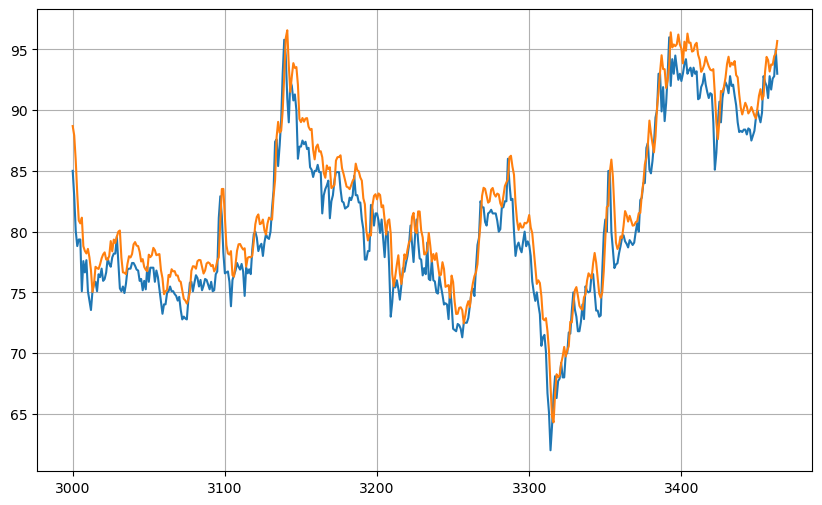

[88.69301  87.91907  85.86219  83.103745 80.91177  80.67935  81.148254
 78.804054 78.410065 78.20447  78.58132  77.88002  76.82666  75.04262
 75.69498  77.10595  76.99878  76.926025 77.30976  77.802475 78.12381
 78.29331  77.71069  77.6906   77.993286 79.22336  78.379135 79.34996
 79.06438  79.5904   79.99744  80.0931   77.86685  76.64691  76.61679
 76.503914 77.35127  77.97616  77.87129  78.15085  78.94997  79.14134
 78.849976 78.80968  78.33852  77.54186  77.73743  77.09518  76.86429
 76.74725  78.10407  77.90077  78.055756 78.664444 78.478386 78.0605
 78.118286 78.1525   76.826294 76.16374  74.849594 75.07958  75.204575
 76.43387  76.2816   76.90474  76.72875  76.751526 76.39824  76.389465
 75.955635 75.86754  75.18699  74.46835  74.33099  74.07953  74.41735
 75.04317  76.77713  77.15418  77.13193  76.95022  77.56467  77.672325
 77.647964 77.079346 76.55148  76.80223  77.37709  77.47539  77.3884
 77.1586   77.25978  76.727234 76.99486  77.6012   77.89301  80.82912
 83.51083  83.5183

In [16]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [17]:
# Compute the MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

4.974321


## Wrap Up

In this lab, you built a relatively simple DNN to forecast VCB stock price for a given day. We encourage you to tweak the parameters or train longer and see the best results you can get. 